# Improve training of U-Nets with data generators & augmentation

This tutorial describes how to use data augmentation to improve the training of U-Nets for salt classification.


## Setup ##

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-3/tutorial-3.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [1]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

Next we clone the Github repository to get our data:

In [2]:
!git clone https://github.com/thilowrona/seismic_deep_learning

Cloning into 'seismic_deep_learning'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 411 (delta 8), reused 1 (delta 0), pack-reused 395
Receiving objects: 100% (411/411), 12.66 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (198/198), done.


Now you can load and plot the seismic image and its mask:

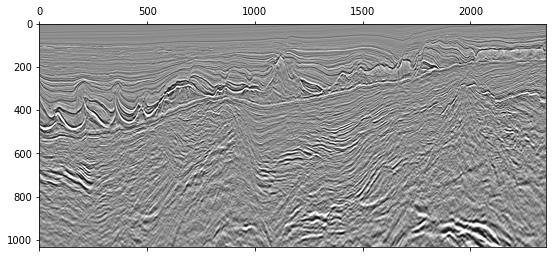

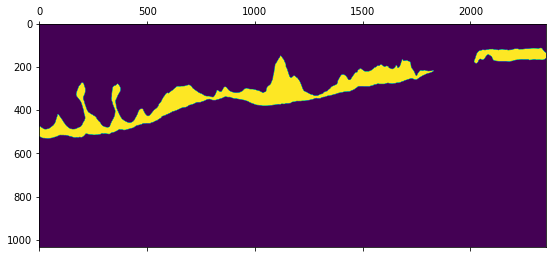

In [3]:
data = mpimg.imread('seismic_deep_learning/tutorial-2/seismic.tif')
data = data[:,:,:1]/255

mask = mpimg.imread('seismic_deep_learning/tutorial-2/mask.tif').copy()
mask = (mask-mask.min())/(mask.max()-mask.min())

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)

At this point, we previously split up the image and mask into 10.000 pairs of small patches. Let's say we want to use 100.000 and 10.000.000 training examples. Usually, they won't fit into memory, but we can use a data generator to produce examples on the fly.

But first, we need to modify our function for the extraction of the patches slightly, because we want to extract patches based on the coordinates of their centres.

In [11]:
def extract_patches(data, mask, num, size, x_centers, t_centers):

  X = np.empty((num, size, size, 1))
  Y = np.empty((num, size, size, 1))

  for n in range(num): 
    # Extract data and mask patch around point 
    X[n,:,:,0] = data[t_centers[n]-size//2:t_centers[n]+size//2, x_centers[n]-size//2:x_centers[n]+size//2, 0]
    Y[n,:,:,0] = mask[t_centers[n]-size//2:t_centers[n]+size//2, x_centers[n]-size//2:x_centers[n]+size//2]

  return X, Y

We also want to augment our training data, for example, by mirroring every image left to right:

In [12]:
def flip_left_right(X, Y):

    X_flip = np.empty_like(X)
    Y_flip = np.empty_like(Y)

    for n in range(X.shape[0]):
        X_flip[n,:,:,0] = np.fliplr(X[n,:,:,0])
        Y_flip[n,:,:,0] = np.fliplr(Y[n,:,:,0])

    return X_flip, Y_flip



Now we can create our class of data generators. We will cheat a bit by using the Keras' template for data generators:

In [13]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self,
                 data,
                 mask,
                 number,
                 size,
                 batch_size, 
                 flip=False):

        # Initilisation
        self.data = data
        self.mask = mask
        self.number = number
        self.size = size
        self.batch_size = batch_size
        self.flip = flip

        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

        # Generation of centers for patches
        (t_max, x_max, _) = self.data.shape
        self.x_centers = np.random.randint(self.size//2, x_max-self.size//2, self.number)
        self.t_centers = np.random.randint(self.size//2, t_max-self.size//2, self.number)
        

    def __len__(self):
        # Returns number of batches per epoch
        return int(np.floor(self.number / self.batch_size))

    def __getitem__(self, idx):
        # Get centers belonging to idx
        self.x_batch = self.x_centers[idx*self.batch_size:(idx+1)*self.batch_size]
        self.t_batch = self.t_centers[idx*self.batch_size:(idx+1)*self.batch_size]



        # Get the corresponding data and mask
        X, Y = self.__data_generation()

        return X, Y

    def __data_generation(self):
        
        if self.flip:
            X, Y           = extract_patches(self.data, self.mask, self.batch_size//2, self.size, self.x_batch, self.t_batch)
            X_flip, Y_flip = flip_left_right(X, Y)
            X, Y           = np.concatenate((X, X_flip), axis=0), np.concatenate((Y, Y_flip), axis=0)

        else:
            X, Y = extract_patches(self.data, self.mask, self.batch_size, self.size, self.x_batch, self.t_batch)

        return X, Y


    def __next__(self):
      if self.n >= self.max:
        self.n = 0
      result = self.__getitem__(self.n)
      self.n += 1
      return result




Now we create a data generator for training and for validation with 100 000 examples of our data:

In [23]:
batch_size    = 32                                                              # Size of mini-batches
examples_num  = 100000                                                          # Number of examples
size          = 128                                                             # Size of examples (128x128)
val_split     = 0.2                                                             # Validation split

datagen_train = DataGenerator(data[:,:1500],
                              mask[:,:1500],
                              int(examples_num*(1-val_split)),
                              size,
                              batch_size=32, 
                              flip=True)

datagen_val   = DataGenerator(data[:,1500:],
                              mask[:,1500:],
                              int(examples_num*(val_split)),
                              size,
                              batch_size=32, 
                              flip=False)

Before training, it's always a good idea to look at the training data, so let's do that:

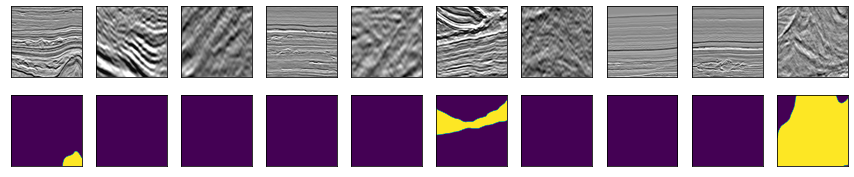

In [24]:
X_train_batch, Y_train_batch = next(datagen_train)


fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(X_train_batch[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(Y_train_batch[k,:,:,0], interpolation='spline16', aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1


What do you notice?

* Is it an easy task?
* Could you predict the masks?
* Can we learn more from some examples?

### Training ##
To train our model, we need to define its architecture. 



In [20]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((size, size, 1))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model




model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Now you can train your convolutional neural net using the data generator:

In [22]:
history =  model.fit(datagen_train,
                     steps_per_epoch  = len(datagen_train),
                     validation_data  = datagen_val,
                     validation_steps = len(datagen_val),
                     epochs=1)

2500/2500 [==============================] - 403s 161ms/step - loss: 0.0633 - acc: 0.9762 - val_loss: 0.2279 - val_acc: 0.9592


##Application##
Now we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image:

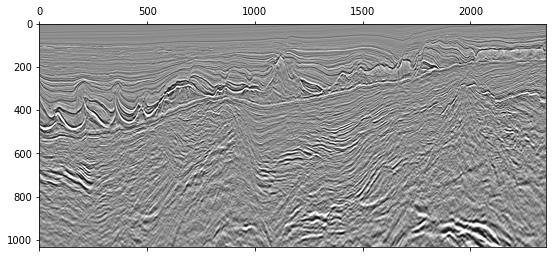

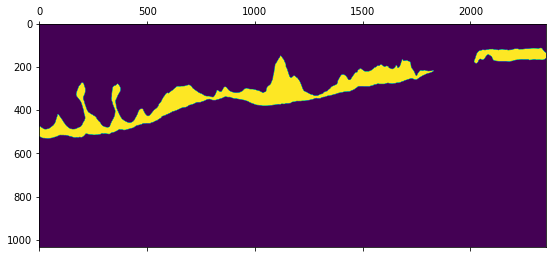

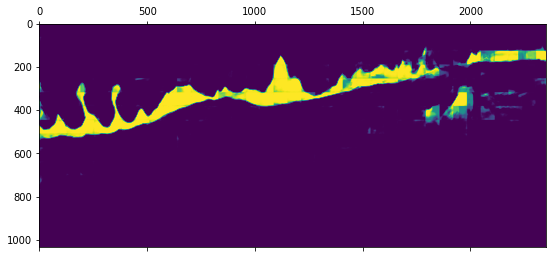

In [26]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max, _) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,1)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x_max-wsize:x_max,0]
            elif x_max - x < wsize:
                data_patch[n,:,:,0] = data[t:t+wsize, x_max-wsize:x_max,0]
            elif t_max - t < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x:x+wsize,0]
            else:
                data_patch[n,:,:,0] = data[t:t+wsize,x:x+wsize,0]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,1))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count


dt = 64
dx = 64

(t_max, x_max, _) = data.shape

data_tiles = tile(data, size, dt, dx)
result_tiles = model.predict_on_batch(data_tiles)
result = merge(result_tiles, t_max, x_max, size, dt, dx)


plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()



Awesome! The model did a pretty good job on the training data (left side of the image), but on yet unseen data (right side of the image), it still struggles a bit. Maybe we need multiple sections to improve our model. In the next tutorial ([tutorial-4](https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-4/tutorial_4.ipynb)), we will see how to use multiple sections of 3-D seismic reflection data.